# classification(using fashion MNIST)
# with simple CNN



## 분류 모델 전체를 위해서 필요한 내용

1. 데이터 셋 제작 모듈(일단 전처리가 없는 데이터 셋 사용)
  - Fashion MNIST, 단순히 불러오는 형태로 사용 가능
  - train, validation 데이터 셋
2. CNN 전반적인 내용
  - Conv layer
  - max pooling layer
  - activation function
3. 학습 데이터를 저장하여 보여주는 모듈
  - 500회의 미니 배치를 기준으로 평균 loss계산


## 데이터 셋 가져오기

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST

In [ ]:
# 일단 학습이 더 빨라진다고 하여, Normalize를 넣어서 진행.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5,), std=(0.5))]
    )

In [ ]:
!rm -rf /content/FashionMNIST/
!rm -rf /content/model/

In [ ]:
!mkdir /content/model

In [ ]:
# 제공해주는 방식대로, train, validation, test 데이터셋으로 나눠서 다운 받고, 텐서 변환, Normalize 를 진행한다.
train_set = FashionMNIST(root='/content',
                        train=True,
                        transform=transform,
                        download=True)

validation_set = FashionMNIST(root='/content',
                              train=False,
                              transform=transform,
                              download=True)

# test_set = FashionMNIST(root='/content',
#                         train=False,
#                         transform=transform,
#                         download=True)


100%|██████████| 26421880/26421880 [00:01<00:00, 18086054.88it/s]


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 298939.14it/s]


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5443200.42it/s]


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4852197.08it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [ ]:
print(type(train_set))

<class 'torchvision.datasets.mnist.FashionMNIST'>


In [ ]:
# 데이터 간략 확인
print(train_set.data.shape, train_set.targets.shape)
print(validation_set.data.shape, validation_set.targets.shape)
print(test_set.data.shape, test_set.targets.shape)

torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([10000, 28, 28]) torch.Size([10000])
torch.Size([10000, 28, 28]) torch.Size([10000])


In [ ]:
sample_image = train_set.data[:10]
print(sample_image.shape)

torch.Size([10, 28, 28])


torch.Size([60000, 28, 28])
torch.Size([60000])
<class 'torch.Tensor'>
Bag


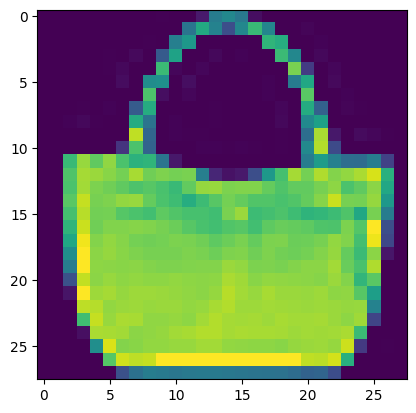

In [ ]:
# normalize 를 왜 해야되는지 모르겠으니, 원본 데이터를 확인해보자.
import matplotlib.pyplot as plt
print(train_set.data.shape)
print(train_set.targets.shape)

# 1장 뽑아서 보자.
sample_image = train_set.data[100, :, :]
print(type(sample_image))

imgplot = plt.imshow(sample_image)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')
print(classes[train_set.targets[100].item()])

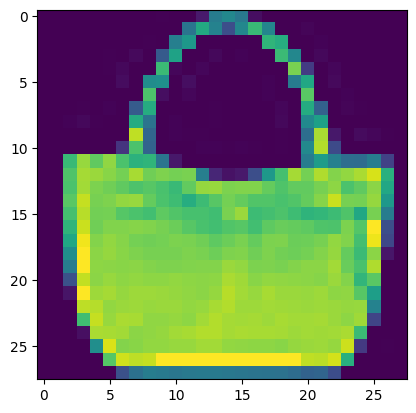

In [ ]:
# Normalize 한 것과 하지 않은 것을 비교해보자.

"""
torchvision.transforms.Normalize를 사용하면 제공된 평균과 표준 편차에 따라 이미지의 픽셀 값을 표준화할 수 있습니다.
이는 데이터 분포가 일관되게 유지되고 딥러닝 네트워크와 같은 기계 학습 모델의 효과적인 훈련에 도움이 됩니다.

Normalization을 하는 큰 이유 : optimal solution을 더 빠르게 찾아가고자 함.
-> 그말은 즉, 여러 이미지에 대해서, 데이터셋 전체에 대해서 작용해야 하는 것 처럼 보임.
"""

from torchvision.transforms import Normalize, ToTensor

normalize_transform = Normalize(mean=(0.5,), std=(0.5,))

sample_image = sample_image.unsqueeze(dim=0)

normalized_image = normalize_transform(sample_image.float())
# print(normalized_image.squeeze(dim=0))

imgplot = plt.imshow(normalized_image.squeeze())

In [ ]:
# 각 픽셀간 차이를 구해서 얼마나 차이나게 변했는지 확인해보자
print(sample_image)
print(normalized_image)
# 차이가 있긴 한데...유효한지 잘 모르겠음.


# 학습시에 차이가 난다고 하니, 일단 적용시켜놓자.

In [ ]:
# 모델에 데이터를 넣을 때, 배치를 기준으로 넣을 것이다.
from torch.utils.data import DataLoader, Dataset
training_loader = DataLoader(train_set, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=16, shuffle=False)
# 매번 일관된 평가를 위해서는 같은 데이터로 평가해야함. -> 여러 데이터로 랜덤하게 평가시 지표를 믿기가 어려워짐. -> shuffle=False
# validation set이 "일반 데이터" 라고 가정

데이터 타입이 uint8인데, float32를 요하는것을 보면, 어딘가에서 데이터 타입이 변경되었음을 알 수 있다.

학습을 시킬 때, 로더를 거치면서 type변경이 발생됨(uint8 -> float32)

# 모델 생성

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    # 내가 모델에 사용할 레이어 설정
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)  # 처음(1*28*28 사이즈가 들어가서, 6*24*24 가 된다.
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 6*24*24 -> 6*12*12
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)  # 6*12*12 -> 16*8*8
    # flatten 할 수 있는 함수가 필요함. 그래야 fully connected layer에 넣지.
    self.fc1 = nn.Linear(in_features=16*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=40)
    self.fc3 = nn.Linear(in_features=40, out_features=10)

    # self.relu = F.relu()
    # self.softmax = F.Softmax()

  def forward(self, x):
    # conv -> relu -> pool
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool1(x)
    # -> conv -> pool -> relu -> 벡터로 변환-> fc1 -> relu -> fc2 -> relu
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool1(x)
    x = x.view(-1, 16*4*4)  # flatten
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)

    # print(x.shape)  # (16, 10) 이렇게 나오는 이유는 배치 사이즈 16, 각각은 10개의 클래스에 대한 값이 나오는거지.

    return x

In [ ]:
# 모델 객체 생성
model = CNN()

# 손실함수

In [ ]:
# 손실함수를 사용하여 batch 만큼 넣었을 때 나온 loss를 가지고, CNN kernel내 파라미터들을 조율해야함.
# 어떤 손실함수 사용?
# https://modulabs.co.kr/blog/loss-function-machinelearning/
# 여기에서는 다중 클래스 분류 문제에 적합한 cross_entropy 사용
import torch
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저

In [ ]:
# optimization

lr = 0.001
momentum=0.9
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# model.parameters()로 내가 만든 모델의 파라미터들을 알아서 다 업데이트 되도록 옵티마이저에 넘겨준다.
# 매우 효율적이네.

# 1 Epoch 학습 내용

In [ ]:
# 학습을 돌리는 내용
"""
1. DataLoader에서 Batch사이즈만큼 데이터를 빼오고
2. 파이토치 gradient값을 0으로 초기화 하고 -> 배치마다 중첩될 수 있음.
3. 데이터입력 및 결과 도출 -> 손실값 계산
4. 가중치 업데이트(backpropagation)
5. 500개의 배치마다 평균 loss값 계산
"""

In [ ]:
# 일단 1epoch에 대해서 하고, 그다음에는 여러 epoch 수행

def train_one_epoch():
  running_loss = 0

  for i, data in enumerate(training_loader):
    input_image, label = data

    # gradient 초기화
    optimizer.zero_grad()

    # 모델을 통한 출력
    outputs = model(input_image)

    # loss 계산
    loss = loss_fn(outputs, label)

    # backpropagation
    loss.backward()

    # 가중치 업데이트(w -= lr*loss)
    optimizer.step()

    # 학습이 잘 되는지 확인하기 위한, loss 저장
    running_loss += loss.item()

    # 지금 배치 16인데, 60000개 데이터 있으니, 500번의 배치마다 loss 누적을 출력해보자.
    if i % 500 == 499:
      print(f"batch : {i}, loss : {running_loss/500}")  # average loss per batch
      running_loss = 0


  model_path = f'/content/model/this_model'
  torch.save(model.state_dict(), model_path)

# 10 Epoch로 학습 진행

- 1 Epoch 마다 validation dataset으로 평균 loss값 계산 및 출력



In [ ]:
epoch = 10

for i in range(epoch):
  model.train(True)
  train_one_epoch()  # 1  epoch

  model.eval()
  with torch.no_grad():
    running_vloss = 0
    for j, vdata in enumerate(validation_loader):
      vinput_image, vlabels = vdata
      voutput = model(vinput_image)
      vloss = loss_fn(voutput, vlabels)
      running_vloss += vloss

    print(f"epoch{i}, validation_loss : {running_vloss/(j+1)}")

batch : 499, loss : 2.1850373046398164
batch : 999, loss : 1.0783913956284523
batch : 1499, loss : 0.7839787123203278
batch : 1999, loss : 0.7223969936668873
batch : 2499, loss : 0.6859933748245239
batch : 2999, loss : 0.6412878237366676
batch : 3499, loss : 0.6298586182892323
epoch0, validation_loss : 0.600139856338501
batch : 499, loss : 0.5745830549895763
batch : 999, loss : 0.5480311042964459
batch : 1499, loss : 0.5384336487203837
batch : 1999, loss : 0.5234422384202481
batch : 2499, loss : 0.5059343313425779
batch : 2999, loss : 0.4977994274199009
batch : 3499, loss : 0.4967309193313122
epoch1, validation_loss : 0.48256075382232666
batch : 499, loss : 0.4713804243654013
batch : 999, loss : 0.45415576492249965
batch : 1499, loss : 0.43965462955087425
batch : 1999, loss : 0.4199612812548876
batch : 2499, loss : 0.43368055261671545
batch : 2999, loss : 0.428878666549921
batch : 3499, loss : 0.415609248585999
epoch2, validation_loss : 0.44640326499938965
batch : 499, loss : 0.3967733

# 위에서 학습된 모델 사용, 이미지 1장을 이용한 인퍼런스 시도

- 처음에 그냥 이미지 1장을 모델에 입력하려 하니, 사이즈가 맞지 않는 문제가 있었음.(학습시킬 때에는 (16, 1, 28, 28) 포맷으로 학습시켰으나, 단순히 이미지를 빼왔을 때에는 (28, 28) 포맷이었음.) 따라서 .unsqueeze(0)를 2번 사용하여 (1, 1, 28, 28)로 변경했음
- 2번째로는 그냥 이미지만 모델에 넣을 때에는 이미지 내의 데이터가 uint(0~255)값이었고, 모델은 float32 타입을 원했음. 따라서 .type(torch.float32)을 통해 타입 변경을 하였음.



-  **위와 같이 했을 시, 정답을 10개 중에 3개밖에 못 맞추는 문제가 있었음 학습 시, validation dataset loss도 같이 낮아져서 학습이 잘 되는 것 같았음**

In [ ]:
# 저장된 모델 가져와서, validation 데이터를 사용한 평가 수행
model_path = '/content/model/this_model'

model = CNN()
model.load_state_dict(torch.load(model_path))

# inference 이므로, 가중치 업데이트 되면 안됨.
model.eval()

with torch.no_grad():
  # 이미지 1장, 라벨 1장 가지고 정상적으로 잘 분류가 되는지 확인.

  sample_train_image = train_set.data[27, :, :]
  sample_train_label = train_set.targets[27]
  # imgplot = plt.imshow(sample_train_image)

  classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

  print(classes[sample_train_label.item()])
  inference_loader = DataLoader(train_set, batch_size=1, shuffle=False)

  # sample_train_image = sample_train_image.view(1, 1, 28, 28)
  # sample_train_image = sample_train_image.unsqueeze(0).unsqueeze(0)
  # print(sample_train_image)
  # print(type(sample_validation_image), sample_validation_image.dtype)
  # sample_train_image = sample_train_image.type(torch.float32)
  # print(sample_train_image)

  sample_train_image = sample_train_image.unsqueeze(0).unsqueeze(0)

  # sample_train_image = a(sample_train_image.type(torch.float32))
  # splot = plt.imshow(sample_train_image)

  print(sample_train_image)

  # sample_train_image = sample_train_image.unsqueeze(0).unsqueeze(0)

  # result = model(sample_train_image)
  # print(result)


In [ ]:
# https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html

# 이미지 1장에 대한, inference를 위해서 customdataset, customdataloader를 제작한다.

In [ ]:
# validation 과정을 넣어서, validation log를 비교했을 때, 더 떨어지지 않으면 종료 되도록.

## 내용 일부 정리

- 전체 데이터를 "배치"라 하고, 전체 데이터에서 일부분씩 샘플링 된 것을 "미니배치"라고 부른다.
- 사람에 따라서 다르게 부르는 것 같다. 다만 "미니배치"라는 말이 나오면 위와 같이 쓰인 것 같다.

# 아래는 토치 데이터셋, 데이터로더를 직접 건드려보았음

In [1]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self, annotation_data, image_data, transform=None, target_transform=None):
    # 라벨 데이터 읽어옴.
    self.annotation_data = annotation_data  # ['1', '2', '3', '4']
    # 예시에서는 이미지 디렉토리를 연결함.
    self.image_data = image_data  # [[[1, 1], [1, 1]], [[2, 2], [2, 2]], [[3, 3], [3, 3]], [[4, 4], [4, 4]]]

    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    # 데이터 셋의 샘플 갯수 반환
    return len(self.annotation_data)

  def __getitem__(self, idx):
    # 주어진 인덱스(idx)의 샘플을 데이터셋에서 불러봐서 반환
    # 위에 self.img_data 가 아닌, self.img_dir로 했으면, 여기에서 해당 경로의 해당 인덱스에 맞는
    # 이미지 데이터를 가져와서 저장.
    # 나는 위에 그냥 데이터를 넣었으니, 그냥 그대로 불러왔음.
    label = self.annotation_data[idx]
    image = self.image_data[idx]

    # 만약 transform을 정의해놨다면, transform 수행
    if self.transform:
      image = self.transform(image)

    # 최종적으로 출력할 데이터 지정
    sample = (image, label)

    return sample


In [2]:
from torch.utils.data import DataLoader

annotation_data = ['1', '2', '3', '4']
image_data = [11, 22, 33, 44]

sample_dataset = CustomDataset(annotation_data, image_data)

sample_dataloader = DataLoader(sample_dataset, batch_size=1, shuffle=False)

In [3]:
for i in range(4):
  image, label = next(iter(sample_dataloader))
  print(image)
  print(label)

tensor([11])
('1',)
tensor([11])
('1',)
tensor([11])
('1',)
tensor([11])
('1',)


In [4]:
for image, label in sample_dataloader:
  print(image)
  print(label)

tensor([11])
('1',)
tensor([22])
('2',)
tensor([33])
('3',)
tensor([44])
('4',)


# 이미지 10장 데이터셋, 데이터로더 만들어서 입력 후 인퍼런스 시도

In [5]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self, annotation_data, image_data, transform=None, target_transform=None):
    self.annotation_data = annotation_data
    self.image_data = image_data

    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    # 데이터 셋의 샘플 갯수 반환
    return len(self.annotation_data)

  def __getitem__(self, idx):
    label = self.annotation_data[idx]
    image = self.image_data[idx]

    # 만약 transform을 정의해놨다면, transform 수행
    if self.transform:
      image = self.transform(image)

    # 최종적으로 출력할 데이터 지정
    sample = (image, label)

    return sample

In [ ]:
sample_train_image = train_set.data[:10]
sample_train_label = train_set.targets[:10]  # .unsqueeze(0)
print(sample_train_image.shape, sample_train_label.shape)

torch.Size([10, 28, 28]) torch.Size([10])


In [ ]:
from torch.utils.data import DataLoader

annotation_data = train_set.targets[:10]
image_data = train_set.data[:10].unsqueeze(1)
# sample_train_image = sample_train_image.unsqueeze(0).unsqueeze(0)


sample_dataset = CustomDataset(annotation_data, image_data)

sample_dataloader = DataLoader(sample_dataset, batch_size=1, shuffle=False)

In [ ]:
# 저장된 모델 가져와서, validation 데이터를 사용한 평가 수행
model_path = '/content/model/this_model'

model = CNN()
model.load_state_dict(torch.load(model_path))

# inference 이므로, 가중치 업데이트 되면 안됨.
model.eval()

with torch.no_grad():
  classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

  # sample_train_image = sample_train_image.unsqueeze(0).unsqueeze(0)

  for sample_image, sample_label in sample_dataloader:

    # print(sample_image.shape, sample_label.shape)

    sample_image = sample_image.type(torch.float32)
    # print(sample_image.shape)
    result = model(sample_image)
    _, predicted = torch.max(result, 1)
    print(predicted)
    print(sample_label)
    print("-------------------")

tensor([8])
tensor([9])
-------------------
tensor([0])
tensor([0])
-------------------
tensor([1])
tensor([0])
-------------------
tensor([0])
tensor([3])
-------------------
tensor([0])
tensor([0])
-------------------
tensor([2])
tensor([2])
-------------------
tensor([8])
tensor([7])
-------------------
tensor([8])
tensor([2])
-------------------
tensor([8])
tensor([5])
-------------------
tensor([8])
tensor([5])
-------------------


In [ ]:
# 어....못 맞추네....